In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold,cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import lightgbm as lgb
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../Base_Umbilo.csv', sep=';',decimal=',')
df.set_index('Dia', inplace=True)

df

Q_entrada  NH_entrada  TSS_entrada  DQO_entrada  DBO_entrada  \
Dia                                                                          
0.000000    4719.000000   21.000000   271.000000   391.000000   198.575000   
0.041667    4766.833372   21.041667   271.208333   391.375000   198.761875   
0.083333    4814.666743   21.083333   271.416667   391.750001   198.948750   
0.125000    4862.500115   21.125000   271.625000   392.125001   199.135625   
0.166667    4910.333486   21.166667   271.833334   392.500001   199.322501   
...                 ...         ...          ...          ...          ...   
364.833625  2891.467657   17.166375   173.332750   246.831874   126.034431   
364.875292  2767.884225   17.124708   173.249416   246.623540   125.953181   
364.916959  2644.300792   17.083041   173.166083   246.415207   125.871931   
364.958625  2520.717360   17.041375   173.082749   246.206873   125.790681   
365.000000  2334.275029   16.978515   172.957030   245.892574   125.668104   

            TN_entrada  TKN_entrada  TP_entrada  PO_entrada      Q_saida  \
Dia                                                                        
0.000000     34.060000    34.060000    8.020000         4.6  6135.066621   
0.041667     34.114167    34.114167    8.023333         4.6  4536.546366   
0.083333     34.168333    34.168333    8.026667         4.6  4584.379743   
0.125000     34.222500    34.222500    8.030000         4.6  4632.213115   
0.166667     34.276667    34.276667    8.033333         4.6  4680.046486   
...                ...          ...         ...         ...          ...   
364.833625   25.411331    25.411331    6.756655         4.6  2662.209157   
364.875292   25.363414    25.363414    6.754988         4.6  2538.625725   
364.916959   25.315498    25.315498    6.753322         4.6  2415.042292   
364.958625   25.267581    25.267581    6.751655         4.6  2291.458860   
365.000000   25.195292    25.195292    6.749141         4.6  2105.016529   

            NH_saida   NO_saida  TSS_saida  DQO_saida  DBO_saida   TN_saida  \
Dia                                                                           
0.000000    3.854908   0.079306   6.642565  83.782370   3.890641   5.042310   
0.041667    3.110403   0.235010   6.475226  81.485161   3.157472   4.427449   
0.083333    2.429280   0.285368   6.328465  80.156342   3.032321   3.777312   
0.125000    1.858492   0.298568   6.245022  78.986079   2.977202   3.204324   
0.166667    1.417633   0.298687   6.193657  77.894845   2.946727   2.750241   
...              ...        ...        ...        ...        ...        ...   
364.833625  0.117794  18.804470   3.245100  33.145931   1.527409  19.358707   
364.875292  0.114032  18.859135   3.270412  33.142325   1.527662  19.410103   
364.916959  0.110285  18.915739   3.302093  33.144707   1.529204  19.463677   
364.958625  0.106555  18.974251   3.341246  33.153967   1.532223  19.519437   
365.000000  0.100947  19.066666   3.417396  33.183656   1.540150  19.608314   

            TKN_saida  TP_saida  PO_saida  
Dia                                        
0.000000     4.963005  0.428499  0.326124  
0.041667     4.192439  0.671496  0.573663  
0.083333     3.491944  1.125122  1.029731  
0.125000     2.905757  1.626430  1.532398  
0.166667     2.451555  2.150652  2.057467  
...               ...       ...       ...  
364.833625   0.554237  5.624398  5.579316  
364.875292   0.550968  5.688779  5.643467  
364.916959   0.547938  5.754875  5.709267  
364.958625   0.545186  5.822656  5.776672  
365.000000   0.541648  5.928673  5.881943  

[8761 rows x 19 columns]

In [3]:
y = df['DQO_saida']
X = df.drop(['DQO_saida',
            'Q_saida',
            'NH_saida',
            'NO_saida',
            'TSS_saida',
            'DBO_saida',
            'TN_saida',
            'TKN_saida',
            'TP_saida',
            'PO_saida',
            'DBO_entrada',
            'DQO_entrada',
            'TKN_entrada',
            'TP_entrada',
            'PO_entrada'], axis=1)

print("X", X.shape)
print("y", y.shape)

X (8761, 4)
y (8761,)


In [4]:
seed = 42

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, shuffle=False, test_size=0.082) 
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (719, 4)
Test set y (719,)


In [5]:
# Padronização (Standardization) para o y
# Sempre usar os dados de treino apenas para construir o modelo, então transformar o teste com base no treino (como se o teste fossem dados novos)
y_train = np.array(y_training).reshape(len(y_training),1)
y_testing = np.array(y_test).reshape(len(y_test),1)

scalery = StandardScaler().fit(y_train)
normalized_y_train = pd.DataFrame(
    scalery.transform(y_train),
    columns = [y_training.name],
    index = y_training.index
)
normalized_y_train = normalized_y_train.squeeze()

normalized_y_test = pd.DataFrame(
    scalery.transform(y_testing),
    columns = [y_test.name],
    index = y_test.index
)
normalized_y_test = normalized_y_test.squeeze()


# Padronização dos previsores (DataFrame X)
scalerX = StandardScaler().fit(X_training)

normalized_x_train = pd.DataFrame(
    scalerX.transform(X_training),
    columns = X_training.columns,
    index = X_training.index
)


normalized_x_test = pd.DataFrame(
    scalerX.transform(X_test),
    columns = X_test.columns,
    index = X_test.index
)

In [6]:
# Epsilon-Support Vector Regression com validação cruzada e Grid Search

# definindo os valores possíveis dos parâmetros a serem testados
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'degree': [x for x in range(2,5,1)],
          'tol': [1e-4],
          'C': [0.5,1,2,3,5],
          'epsilon': [0.01,0.05,0.1,0.5,1]
        } 
          # coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True

# criando o objeto do modelo com SVR
svr_model_cv_gs = SVR()

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(svr_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_mean_absolute_percentage_error')

# treinando o modelo com o grid search
grid_search.fit(normalized_x_train, normalized_y_train)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)



 Best hyperparameters:
{'C': 5, 'degree': 2, 'epsilon': 0.01, 'kernel': 'linear', 'tol': 0.0001}


In [7]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))

# imprimindo o score médio nas bases de validação
print("Average accuracy on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0]))

# configurando o modelo com a melhor combinação de hiperparâmetros
svr_model_cv_gs.set_params(
                           degree = cv_best_params['degree']
                           )

# treinando um modelo com a melhor combinação de hiperparâmetros
svr_model_cv_gs.fit(normalized_x_train, normalized_y_train)
best_model_params = svr_model_cv_gs.get_params()

Average accuracy on train set: -1.409 +/- 0.187
Average accuracy on validation set: -1.426 +/- 0.701


In [9]:
# Realizando a predição no teste
y_test_pred_svr = svr_model_cv_gs.predict(normalized_x_test)

# Desnormalização
y_test_pred_svr = np.array(y_test_pred_svr).reshape(len(y_test_pred_svr),1)
y_test_pred_svr = scalery.inverse_transform(y_test_pred_svr)
y_test_pred_svr = pd.DataFrame(y_test_pred_svr, columns=[normalized_y_test.name], index = normalized_y_test.index)
y_test_pred_svr = y_test_pred_svr.squeeze()

y_test_pred_svr


# Análise dos erros das previsões
rmse_test_svr = math.sqrt(mean_squared_error(y_test, y_test_pred_svr))
mae_test_svr = mean_absolute_error(y_test, y_test_pred_svr)
mape_test_svr = mean_absolute_percentage_error(y_test, y_test_pred_svr)
r2_test_svr = r2_score(y_test, y_test_pred_svr)


df_metricas = pd.DataFrame(data={'RSME':[rmse_test_svr], 'MAE':[mae_test_svr], 'MAPE':[mape_test_svr],'R²':[r2_test_svr]})
df_metricas

RSME        MAE      MAPE        R²
0  16.58996  10.984401  0.228576  0.686339

In [10]:
# Cross-validation para averiguar precisão do modelo na base de treino
print('---------Treino---------')
results = cross_val_score(svr_model_cv_gs,X=X_training,y=y_training,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results)
print('Média: {}\nStd: {}'.format(round(results.mean(),4),round(results.std(),4)))
print('---------Total---------')
# Predição analisada por validação cruzada para o dataset inteiro
results_total = cross_val_score(svr_model_cv_gs,X=X,y=y,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results_total)
print('Média: {}\nStd: {}'.format(round(results_total.mean(),4),round(results_total.std(),4)))

---------Treino---------
[0.34452199 0.25473195 0.28719414 0.24636907 0.2288526  0.20555583
 0.2289971  0.18349078 0.21730441 0.24003037]
Média: 0.2437
Std: 0.0429
---------Total---------
[0.33457033 0.21844534 0.29126601 0.27392974 0.18662786 0.22784932
 0.19122452 0.20634276 0.24061655 0.41364457]
Média: 0.2585
Std: 0.0681


In [11]:
# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia

df_comparacao = pd.concat([y_test,y_test_pred_svr],axis=1)
df_comparacao.columns = ['Valor_Real','Valor_Predito']
df_comparacao['Diferenca_percentual'] = 100*(df_comparacao['Valor_Predito'] - df_comparacao['Valor_Real'])/df_comparacao['Valor_Real']
df_comparacao.sort_index(inplace=True)
df_comparacao

Valor_Real  Valor_Predito  Diferenca_percentual
Dia                                                        
335.083601   82.855864      81.164029             -2.041901
335.125268   82.498896      81.697637             -0.971236
335.166935   82.205463      81.996006             -0.254797
335.208602   81.972441      82.119817              0.179787
335.250268   81.797515      82.138048              0.416312
...                ...            ...                   ...
364.833625   33.145931     107.041422            222.939852
364.875292   33.142325     108.520989            227.439279
364.916959   33.144707     109.845316            231.411338
364.958625   33.153967     111.013730            234.842975
365.000000   33.183656     112.484480            238.975545

[719 rows x 3 columns]

       RSME        MAE      MAPE        R²
0  16.58996  10.984401  0.228576  0.686339


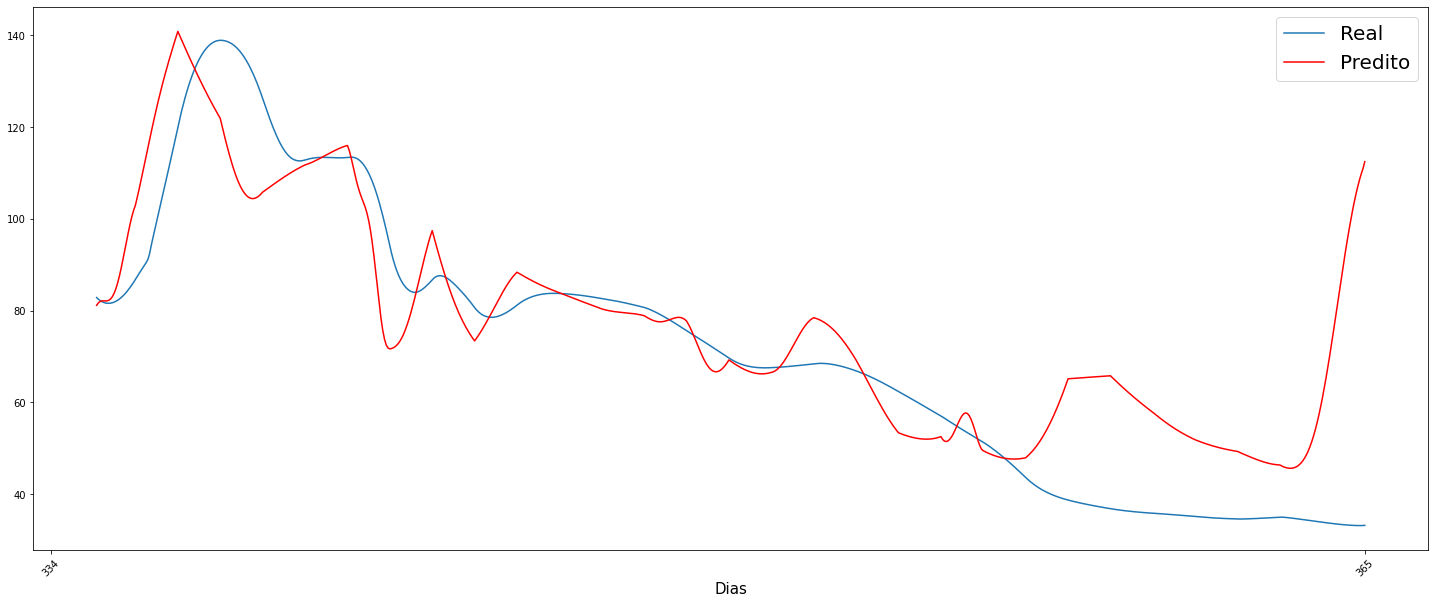

In [12]:
print(df_metricas)
import matplotlib.dates as mdates
# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_comparacao.index, df_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_comparacao.index, df_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [13]:
# Saving predictions

df_comparacao.to_csv("1_2-Previsoes_SVM.csv", encoding='utf-8-sig',sep=';',decimal=',')

# Previsão na base de treino

        RSME        MAE      MAPE        R²
0  18.930969  11.477607  0.108019  0.762965


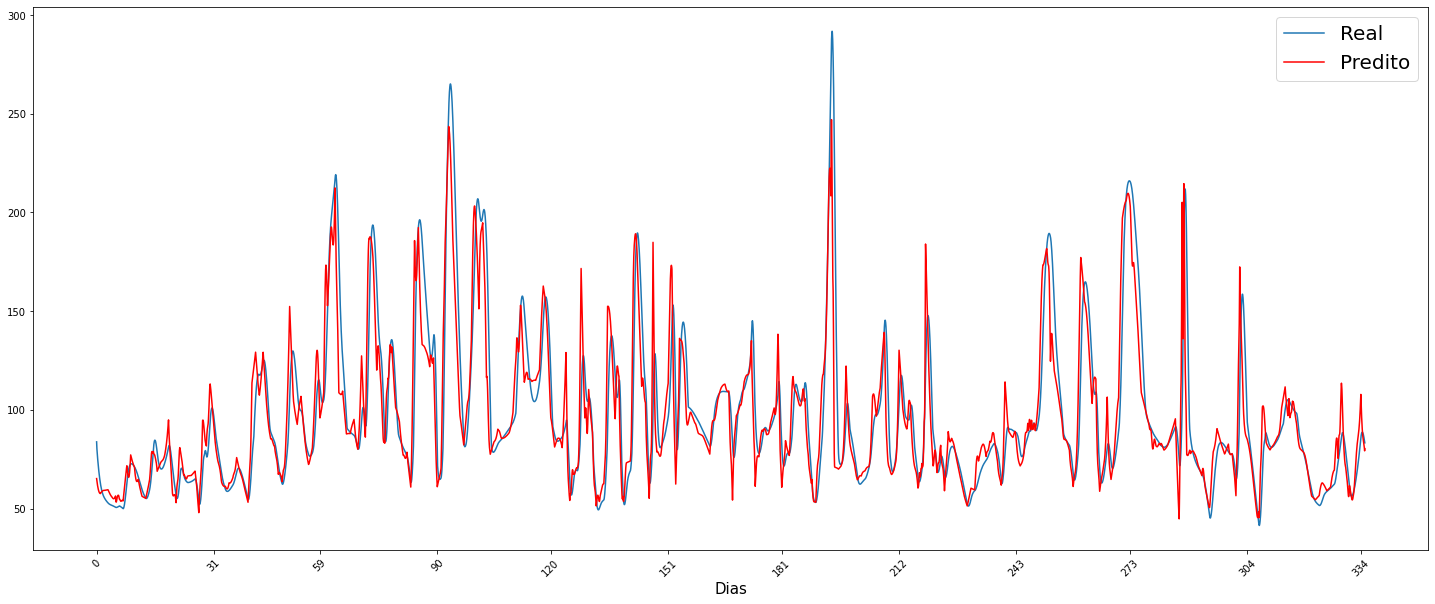

In [14]:
# Realizando a predição no traine
y_train_pred_rf = svr_model_cv_gs.predict(normalized_x_train)

# Desnormalização
y_train_pred_rf = np.array(y_train_pred_rf).reshape(len(y_train_pred_rf),1)
y_train_pred_rf = scalery.inverse_transform(y_train_pred_rf)
y_train_pred_rf = pd.DataFrame(y_train_pred_rf, columns=[normalized_y_train.name], index = normalized_y_train.index)
y_train_pred_rf = y_train_pred_rf.squeeze()

y_train_pred_rf


# Análise dos erros das previsões
rmse_train_rf = math.sqrt(mean_squared_error(y_train, y_train_pred_rf))
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mape_train_rf = mean_absolute_percentage_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
df_train_comparacao = pd.concat([y_training,y_train_pred_rf],axis=1)
df_train_comparacao.columns = ['Valor_Real','Valor_Predito']
df_train_comparacao['Diferenca_percentual'] = 100*(df_train_comparacao['Valor_Predito'] - df_train_comparacao['Valor_Real'])/df_train_comparacao['Valor_Real']
df_train_comparacao.sort_index(inplace=True)
df_train_comparacao


df_train_metricas = pd.DataFrame(data={'RSME':[rmse_train_rf], 'MAE':[mae_train_rf], 'MAPE':[mape_train_rf],'R²':[r2_train_rf]})
print(df_train_metricas)

# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [15]:
# Gráfico de cima, queremos os dados só para o melhor modelo (base de treino)
df_train_comparacao.to_csv('2_2-Previsoes_TREINO_SVM.csv',sep=';',decimal=',',encoding='utf-8-sig')

# FEATURE IMPORTANCE

## PDPs and Permutation Importance

In [16]:
print(normalized_x_train.min())
print(normalized_x_train.max())

Q_entrada     -2.942186
NH_entrada    -2.846533
TSS_entrada   -2.767711
TN_entrada    -2.842474
dtype: float64
Q_entrada      3.060924
NH_entrada     7.473228
TSS_entrada    5.131490
TN_entrada     4.794257
dtype: float64


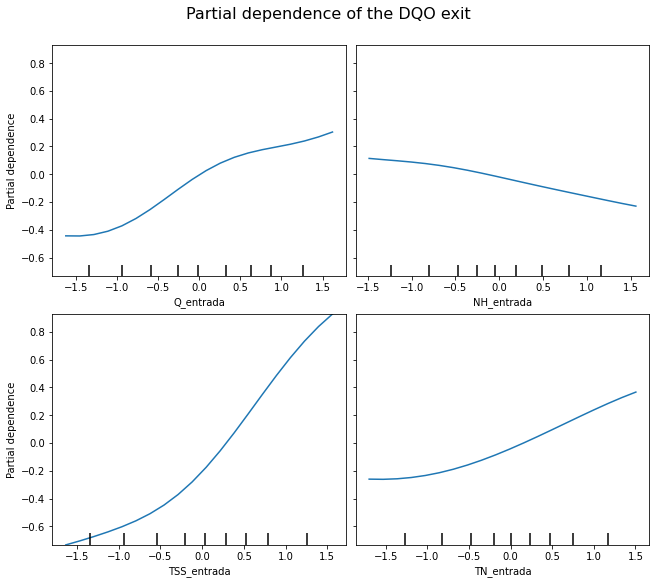

In [17]:
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

# print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": X_training.columns,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    # "categorical_features": categorical_features,
}

_, ax = plt.subplots(ncols=2, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    svr_model_cv_gs,
    normalized_x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(
    "Partial dependence of the DQO exit\n",
    fontsize=16,
)

Tree-based models provide an alternative measure of feature importances based on the mean decrease in impurity (MDI). Impurity is quantified by the splitting criterion of the decision trees (Gini, Log Loss or Mean Squared Error). However, this method can give high importance to features that may not be predictive on unseen data when the model is overfitting. Permutation-based feature importance, on the other hand, avoids this issue, since it can be computed on unseen data.Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories.
Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may be computed performance metric on the model predictions and can be used to analyze any model class (not just tree-based models).

Importance_mean  Importance_std  Importance_mean_normalized
TSS_entrada         0.794641        0.011607                    0.540754
Q_entrada           0.331378        0.012177                    0.225503
TN_entrada          0.213823        0.005237                    0.145507
NH_entrada          0.129663        0.003683                    0.088236

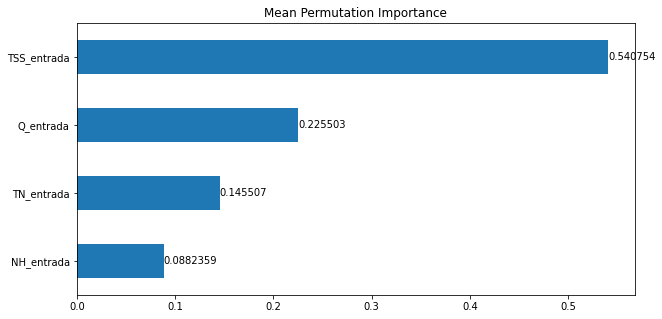

In [18]:
from sklearn.inspection import permutation_importance
r = permutation_importance(svr_model_cv_gs, normalized_x_train, normalized_y_train,
                           n_repeats=30,
                           random_state=0)
# r.importances_mean
# r.importances_std

df_permutation_importance = pd.DataFrame(
    data={'Importance_mean': r.importances_mean,
          'Importance_std': r.importances_std},
    index=normalized_x_train.columns
)

df_permutation_importance['Importance_mean_normalized'] = df_permutation_importance['Importance_mean']/df_permutation_importance['Importance_mean'].sum()

df_permutation_importance = df_permutation_importance.sort_values('Importance_mean',ascending=False)

ax = df_permutation_importance['Importance_mean_normalized'].sort_values(ascending=True).plot.barh(figsize=(10,5), title='Mean Permutation Importance')
ax.bar_label(ax.containers[0])

df_permutation_importance

In [19]:
df_permutation_importance.to_csv('3_2-Permutation_Importance_SVM.csv',sep=';',decimal=',',encoding='utf-8-sig')

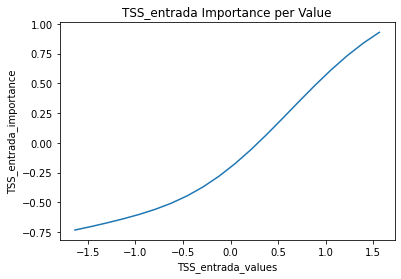

DBO_entrada_importance  Q_entrada_importance  Q_entrada_values  \
0                -0.443605             -0.443605         -1.624177   
1                -0.444403             -0.444403         -1.453397   
2                -0.434126             -0.434126         -1.282618   
3                -0.410161             -0.410161         -1.111839   
4                -0.371411             -0.371411         -0.941059   
5                -0.318612             -0.318612         -0.770280   
6                -0.254344             -0.254344         -0.599501   
7                -0.182715             -0.182715         -0.428721   
8                -0.108761             -0.108761         -0.257942   
9                -0.037649             -0.037649         -0.087163   
10                0.026163              0.026163          0.083616   
11                0.079649              0.079649          0.254396   
12                0.121689              0.121689          0.425175   
13                0.153188              0.153188          0.595954   
14                0.176810              0.176810          0.766734   
15                0.196373              0.196373          0.937513   
16                0.216026              0.216026          1.108292   
17                0.239346              0.239346          1.279072   
18                0.268553              0.268553          1.449851   
19                0.303974              0.303974          1.620630   

    NH_entrada_importance  NH_entrada_values  TSS_entrada_importance  \
0                0.113966          -1.484610               -0.733255   
1                0.105227          -1.324545               -0.704426   
2                0.096971          -1.164480               -0.673253   
3                0.087915          -1.004414               -0.639681   
4                0.077021          -0.844349               -0.602550   
5                0.063626          -0.684284               -0.559758   
6                0.047500          -0.524219               -0.508624   
7                0.028825          -0.364154               -0.446374   
8                0.008105          -0.204088               -0.370676   
9               -0.013976          -0.044023               -0.280138   
10              -0.036708           0.116042               -0.174671   
11              -0.059501           0.276107               -0.055659   
12              -0.081972           0.436172                0.074102   
13              -0.103979           0.596238                0.210673   
14              -0.125583           0.756303                0.349417   
15              -0.146945           0.916368                0.485533   
16              -0.168197           1.076433                0.614589   
17              -0.189306           1.236498                0.732971   
18              -0.209965           1.396563                0.838181   
19              -0.229542           1.556629                0.928939   

    TSS_entrada_values  
0            -1.634561  
1            -1.466265  
2            -1.297970  
3            -1.129674  
4            -0.961378  
5            -0.793082  
6            -0.624787  
7            -0.456491  
8            -0.288195  
9            -0.119899  
10            0.048396  
11            0.216692  
12            0.384988  
13            0.553284  
14            0.721579  
15            0.889875  
16            1.058171  
17            1.226467  
18            1.394762  
19            1.563058

In [20]:
dict_data = {}
df_pdp = pd.DataFrame(display.pd_results[0]['average'].flatten(),columns=['DBO_entrada_importance'])
for i in range(len(display.pd_results)):
    if i!=3 and i!=8: # para o NO, que não tem FI, não temos os 20 dados para plotar
        dict_data[f"{X.columns[i]}_importance"] = display.pd_results[i]['average']
        dict_data[f"{X.columns[i]}_values"]  = display.pd_results[i]['values']
        # df_pdp[f"{X.columns[i]}_importance"] = dict_data[f"{X.columns[i]}_importance"].flatten()
        df_pdp[f"{X.columns[i]}_importance"] = display.pd_results[i]['average'][0]
        df_pdp[f"{X.columns[i]}_values"] = display.pd_results[i]['values'][0]


plt.plot(df_pdp.loc[:, 'TSS_entrada_values'], df_pdp.loc[:, 'TSS_entrada_importance'])
plt.xlabel('TSS_entrada_values')
plt.ylabel('TSS_entrada_importance')
plt.title('TSS_entrada Importance per Value')
plt.show()


df_pdp.to_csv('4_2-PDPs_SVM.csv',encoding='utf-8-sig',decimal=',',sep=';')
df_pdp

In [21]:
# Avaliando na base de TESTE o impacto nas métricas causado pela permutação de valores de cada uma das variáveis.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
r_multi = permutation_importance(
    svr_model_cv_gs, normalized_x_test, normalized_y_test, n_repeats=30, random_state=0, scoring=scoring)

# Apenas mostrar as variáveis cujas importâncias são maiores que 2 vezes o respectivo desvio padrão (para todas as métricas)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}\n")

r2
    TSS_entrada: 0.721 +/- 0.032

    TN_entrada: 0.443 +/- 0.025

    NH_entrada: 0.087 +/- 0.009

neg_mean_absolute_percentage_error
    TSS_entrada: 0.594 +/- 0.063

    NH_entrada: 0.112 +/- 0.044

neg_mean_squared_error
    TSS_entrada: 0.418 +/- 0.019

    TN_entrada: 0.257 +/- 0.014

    NH_entrada: 0.051 +/- 0.005



In [22]:
# Avaliando na base de TREINO o impacto nas métricas causado pela permutação de valores de cada uma das variáveis.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error'] #, 'neg_mean_absolute_error'
r_multi = permutation_importance(
    svr_model_cv_gs, normalized_x_train, normalized_y_train, n_repeats=30, random_state=0, scoring=scoring)

# Apenas mostrar as variáveis cujas importâncias são maiores que 2 vezes o respectivo desvio padrão (para todas as métricas)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}")

r2
    TSS_entrada: 0.795 +/- 0.012
    Q_entrada: 0.331 +/- 0.012
    TN_entrada: 0.214 +/- 0.005
    NH_entrada: 0.130 +/- 0.004
neg_mean_absolute_percentage_error
    TSS_entrada: 1.457 +/- 0.287
    Q_entrada: 1.210 +/- 0.237
    NH_entrada: 0.407 +/- 0.084
neg_mean_squared_error
    TSS_entrada: 0.795 +/- 0.012
    Q_entrada: 0.331 +/- 0.012
    TN_entrada: 0.214 +/- 0.005
    NH_entrada: 0.130 +/- 0.004


## LIME - Local Interpretable Model-Agnostic Explanations 

In [23]:
import lime
import lime.lime_tabular

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(normalized_x_train.values, feature_names=X.columns.values.tolist(),
                                                  class_names=[y.name], verbose=True, mode='regression')

### Cálculo da importância de cada variável para um registro específico

In [24]:
# normalized_x_test.iloc[5]
# normalized_x_test.values[5]

# Choose the 5th instance and use it to predict the results
j = 5
exp = explainer.explain_instance(normalized_x_test.iloc[j], svr_model_cv_gs.predict, num_features=4)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


Intercept 0.22768925511599325
Prediction_local [-0.7069133]
Right: -0.3906844121493178


[('Q_entrada <= -0.76', -0.4065647050924575),
 ('-0.74 < TSS_entrada <= 0.04', -0.3799080788943839),
 ('-0.65 < TN_entrada <= 0.01', -0.10220425711565288),
 ('-0.05 < NH_entrada <= 0.64', -0.04592551776521482)]

Interpretação: O valor Predito é o central da primeira imagem (Predicted value).
As variáveis à esquerda, tiveram influência negativa para o valor predito, enquanto que as variáveis à direita tiveram influência positiva.
Lista de Features com os respectivos valores alimentados para a previsão.

In [25]:
# Choose the 10th instance and use it to predict the results
j = 10
exp = explainer.explain_instance(normalized_x_test.iloc[j], svr_model_cv_gs.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


Intercept -0.0030259663247908884
Prediction_local [-0.04211518]
Right: -0.34595760177467916


[('0.04 < TSS_entrada <= 0.64', 0.13525976238300982),
 ('-0.76 < Q_entrada <= -0.02', -0.11425701031709723),
 ('-0.05 < NH_entrada <= 0.64', -0.09201374937539944),
 ('0.01 < TN_entrada <= 0.58', 0.03192178662279871)]

In [26]:
# Choose the LAST instance and use it to predict the results
j = -1
exp = explainer.explain_instance(normalized_x_test.iloc[j], svr_model_cv_gs.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

exp.as_list()

c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


Intercept 0.2930221390982665
Prediction_local [-0.9508718]
Right: 0.39012889712863413


[('TSS_entrada <= -0.74', -0.7336091010927286),
 ('Q_entrada <= -0.76', -0.39247299935580676),
 ('TN_entrada <= -0.65', -0.3111832722135492),
 ('NH_entrada <= -0.64', 0.19337143210650054)]

In [27]:
# Apply lime to last 20 observations
from interpret.blackbox import LimeTabular
from interpret import show


# Initilize Lime for Tabular data
lime = LimeTabular(model=svr_model_cv_gs, 
                   data=normalized_x_train, 
                   random_state=1)
# Get local explanations
lime_local = lime.explain_local(normalized_x_test, 
                                normalized_y_test, 
                                name='LIME')

show(lime_local)

### Análise de Feature Importance geral com LIME ao invés de apenas para ocorrência específica

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import re
l=[]
for n in range(0,normalized_x_test.shape[0]):
     exp = explainer.explain_instance(normalized_x_test.values[n], svr_model_cv_gs.predict, num_features=X.shape[1])
     a=exp.as_list()
     l.append(a)


df_lime_importances = pd.DataFrame()
for sublist in l:
    row_values = {}
    for condition, value in sublist:
        match = re.search(r'([a-zA-Z_]+)', condition)
        if match:
            text = match.group(1)        
            row_values[text] = value
    df_lime_importances = df_lime_importances.append(row_values, ignore_index=True)

df_lime_importances

Intercept 0.18289034209725055
Prediction_local [-0.58738555]
Right: -0.4153638620404949
Intercept 0.18791624112350244
Prediction_local [-0.57502835]
Right: -0.40164062664341627
Intercept 0.20050587060336383
Prediction_local [-0.65043751]
Right: -0.3939672395854381
Intercept 0.21142563472395723
Prediction_local [-0.70513273]
Right: -0.3907831083961223
Intercept 0.20761674606143216
Prediction_local [-0.70041041]
Right: -0.3903142459250578
Intercept 0.22252013285606412
Prediction_local [-0.68565754]
Right: -0.3906844121493178
Intercept 0.1565581538850918
Prediction_local [-0.5765623]
Right: -0.3900268527495975
Intercept 0.08220748798531259
Prediction_local [-0.31397281]
Right: -0.3865927711783108
Intercept 0.09850341498942387
Prediction_local [-0.38680764]
Right: -0.37885266587188027
Intercept 0.11573376769749566
Prediction_local [-0.41324447]
Right: -0.36558640848622914
Intercept -0.015186473813737781
Prediction_local [-0.00638908]
Right: -0.34595760177467916
Intercept -0.018509029410463

Q_entrada  TSS_entrada  TN_entrada  NH_entrada
0    -0.400826    -0.347994   -0.132496    0.111040
1    -0.408511    -0.376274   -0.103001    0.124841
2    -0.427035    -0.370756   -0.153378    0.100226
3    -0.408315    -0.363769   -0.115909   -0.028565
4    -0.382946    -0.374471   -0.129257   -0.021354
..         ...          ...         ...         ...
714  -0.390720    -0.738220   -0.288322    0.207366
715  -0.401852    -0.742399   -0.301566    0.172582
716  -0.418573    -0.727933   -0.315403    0.214068
717  -0.377244    -0.734330   -0.303971    0.201686
718  -0.400558    -0.736052   -0.313627    0.199072

[719 rows x 4 columns]

In [ ]:
df_lime_absolute_importances = df_lime_importances.copy()

for i in range(df_lime_importances.shape[1]):
    df_lime_absolute_importances.iloc[:,i] = df_lime_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
df_lime_absolute_importances.head()

Q_entrada  TSS_entrada  TN_entrada  NH_entrada
0   0.400826     0.347994    0.132496    0.111040
1   0.408511     0.376274    0.103001    0.124841
2   0.427035     0.370756    0.153378    0.100226
3   0.408315     0.363769    0.115909    0.028565
4   0.382946     0.374471    0.129257    0.021354

In [ ]:
df_lime_absolute_importances.mean()/df_lime_absolute_importances.mean().sum()

Q_entrada      0.207780
TSS_entrada    0.489513
TN_entrada     0.181510
NH_entrada     0.121197
dtype: float64

<Axes: >

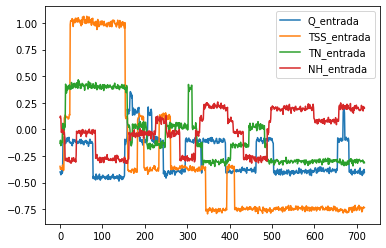

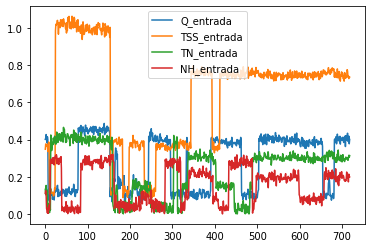

In [ ]:
# df_lime_importances['TN'].plot()
df_lime_importances.plot()
df_lime_absolute_importances.plot()

### Análise de Feature Importance geral com LIME ao invés de apenas para ocorrência específica para a BASE DE TREINO

In [ ]:
l=[]
for n in range(0,normalized_x_train.shape[0]):
     exp = explainer.explain_instance(normalized_x_train.values[n], svr_model_cv_gs.predict, num_features=X.shape[1])
     a=exp.as_list()
     l.append(a)


df_lime_train_importances = pd.DataFrame()
for sublist in l:
    row_values = {}
    for condition, value in sublist:
        match = re.search(r'([a-zA-Z_]+)', condition)
        if match:
            text = match.group(1)        
            row_values[text] = value
    df_lime_train_importances = df_lime_train_importances.append(row_values, ignore_index=True)

df_lime_train_importances

Intercept 0.31648074204403487
Prediction_local [-0.96304882]
Right: -0.826434476949002
Intercept 0.3251894185015105
Prediction_local [-1.03788234]
Right: -0.843524559264264
Intercept 0.31520861376393544
Prediction_local [-1.04023829]
Right: -0.8598179182288834
Intercept 0.3359391528664073
Prediction_local [-1.07319643]
Right: -0.8753045244688513
Intercept 0.3284785030560707
Prediction_local [-0.99770488]
Right: -0.8899768128476819
Intercept 0.3106517641192137
Prediction_local [-1.01561031]
Right: -0.9038296940744632
Intercept 0.32594475525270156
Prediction_local [-1.00718612]
Right: -0.9168605556887492
Intercept 0.3372240815856447
Prediction_local [-1.05553044]
Right: -0.9290692523708559
Intercept 0.32643657956287053
Prediction_local [-1.04654389]
Right: -0.9404580855853784
Intercept 0.31796912351475687
Prediction_local [-0.98524975]
Right: -0.9510317726146704
Intercept 0.312275626016782
Prediction_local [-1.01068241]
Right: -0.9607974051059833
Intercept 0.336325743730166
Prediction_lo

TSS_entrada  Q_entrada  TN_entrada  NH_entrada
0       -0.741891  -0.415308   -0.314629    0.192298
1       -0.742812  -0.394590   -0.298185    0.072514
2       -0.740201  -0.391224   -0.297133    0.073111
3       -0.758763  -0.403820   -0.300535    0.053982
4       -0.751955  -0.382581   -0.266693    0.075046
...           ...        ...         ...         ...
8037    -0.331983  -0.365245   -0.156070    0.099456
8038    -0.356440  -0.396860   -0.156975    0.082676
8039    -0.349209  -0.387071   -0.165095    0.092226
8040    -0.339902  -0.394461   -0.158412    0.100485
8041    -0.358427  -0.423133   -0.130743    0.108733

[8042 rows x 4 columns]

In [ ]:
df_lime_train_absolute_importances = df_lime_train_importances.copy()

for i in range(df_lime_importances.shape[1]):
    df_lime_train_absolute_importances.iloc[:,i] = df_lime_train_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
df_lime_train_absolute_importances

TSS_entrada  Q_entrada  TN_entrada  NH_entrada
0        0.741891   0.415308    0.314629    0.192298
1        0.742812   0.394590    0.298185    0.072514
2        0.740201   0.391224    0.297133    0.073111
3        0.758763   0.403820    0.300535    0.053982
4        0.751955   0.382581    0.266693    0.075046
...           ...        ...         ...         ...
8037     0.331983   0.365245    0.156070    0.099456
8038     0.356440   0.396860    0.156975    0.082676
8039     0.349209   0.387071    0.165095    0.092226
8040     0.339902   0.394461    0.158412    0.100485
8041     0.358427   0.423133    0.130743    0.108733

[8042 rows x 4 columns]

In [ ]:
df_lime_train_absolute_importances.mean()/df_lime_train_absolute_importances.mean().sum()

TSS_entrada    0.470459
Q_entrada      0.214809
TN_entrada     0.184443
NH_entrada     0.130289
dtype: float64

<Axes: >

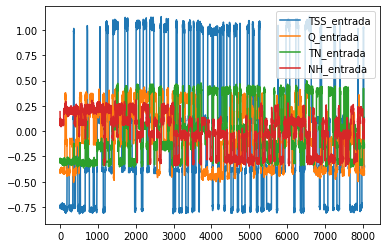

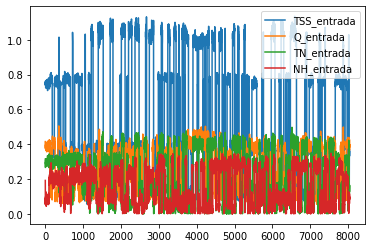

In [ ]:
# df_lime_train_importances['TN'].plot()
df_lime_train_importances.plot()
df_lime_train_absolute_importances.plot()